In [1]:
import sys
sys.path.append('../src/')
import os
import re
import nibabel as nib
import numpy as np
import scipy
import math

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

from finetune_3D import *
from logistic_regression import *
from models import *

In [3]:
def load_experiment(path):
    df = pd.read_csv(path, index_col='Unnamed: 0')
    df.train_BA = df.train_BA.apply(lambda string: np.fromstring(string[1:-1], sep=' '))
    df.train_auroc = df.train_auroc.apply(lambda string: np.fromstring(string[1:-1], sep=' '))
    df.val_BA = df.val_BA.apply(lambda string: np.fromstring(string[1:-1], sep=' '))
    df.val_auroc = df.val_auroc.apply(lambda string: np.fromstring(string[1:-1], sep=' '))
    df.test_BA = df.test_BA.apply(lambda string: np.fromstring(string[1:-1], sep=' '))
    df.test_auroc = df.test_auroc.apply(lambda string: np.fromstring(string[1:-1], sep=' '))
    return df

In [4]:
def split_df(df, index):
    X_train = torch.Tensor(df[df.n<=360]['n'].to_numpy())
    y_train = torch.Tensor(np.array(df[df.n<=360]['test_auroc'].to_list())[:,index])
    X_test = torch.Tensor(df[df.n>360]['n'].to_numpy())
    y_test = torch.Tensor(np.array(df[df.n>360]['test_auroc'].to_list())[:,index])
    return X_train, y_train, X_test, y_test

def train_GP(X, y, training_iter=10000):
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    likelihood.train()
    model = GPPowerLaw(X, y, likelihood)
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    for i in range(training_iter):
        optimizer.zero_grad()
        output = model(X)
        loss = -mll(output, y)
        loss.backward()
        optimizer.step()
    return likelihood, model

def train_model(X, y, training_iter=10000):
    model = PowerLaw()
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_func = nn.MSELoss()
    for i in range(training_iter):
        optimizer.zero_grad()
        output = model(X)
        loss = loss_func(output, y)
        loss.backward()
        optimizer.step()
    return model

In [5]:
# cbi lr=0.1, sbi lr=0.01
df = load_experiment('/cluster/home/eharve06/extrapolating-classifier-accuracy-to-bigger-datasets/experiments/OASIS-3_epochs=3000/n=320_random_state=2001.csv')
print(open('/cluster/home/eharve06/extrapolating-classifier-accuracy-to-bigger-datasets/experiments/OASIS-3_epochs=3000/n=320_random_state=2001.txt').read())
df.tail()

{'wd1': 0.01, 'wd2': 1.0}



,epoch,train_loss,train_BA,train_auroc,val_loss,val_BA,val_auroc,test_loss,test_BA,test_auroc
853,854,0.491905,[0.82230392],[0.87561275],0.546820,[0.75245098],[0.74019608],0.509527,[0.53496503],[0.61421911]
854,855,0.491904,[0.82230392],[0.87561275],0.546819,[0.75245098],[0.74019608],0.509528,[0.53496503],[0.61421911]
855,856,0.491903,[0.82230392],[0.87561275],0.546818,[0.75245098],[0.74019608],0.509528,[0.53496503],[0.61421911]
856,857,0.491902,[0.82230392],[0.87561275],0.546817,[0.75245098],[0.74019608],0.509529,[0.53496503],[0.61421911]
857,858,0.491901,[0.82230392],[0.87561275],0.546816,[0.75245098],[0.74019608],0.509530,[0.53496503],[0.61421911]


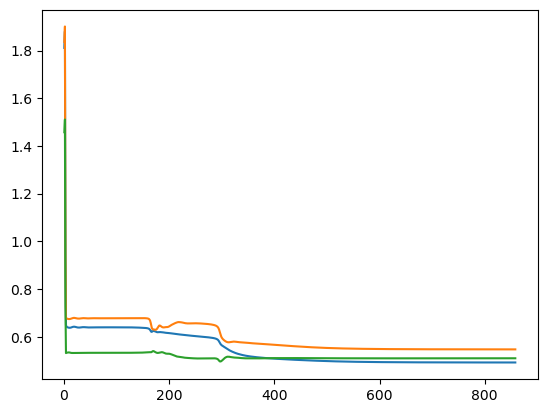

In [6]:
plt.plot(df.epoch.to_list(), df.train_loss.to_list())
plt.plot(df.epoch.to_list(), df.val_loss.to_list())
plt.plot(df.epoch.to_list(), df.test_loss.to_list())

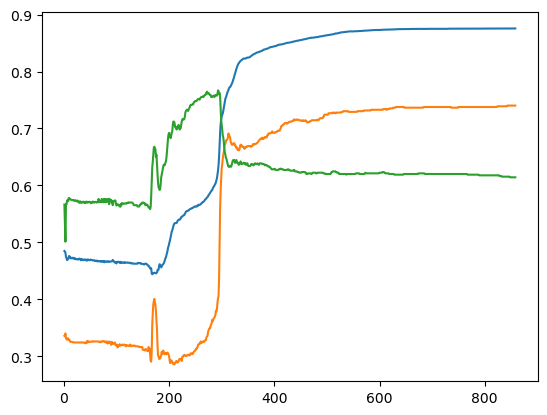

In [7]:
plt.plot(df.epoch.to_list(), np.array(df.train_auroc.to_list())[:,0])
plt.plot(df.epoch.to_list(), np.array(df.val_auroc.to_list())[:,0])
plt.plot(df.epoch.to_list(), np.array(df.test_auroc.to_list())[:,0])

In [8]:
val_performance = np.sum(np.array(df.val_auroc.to_list()), axis=-1)
averaged_performance = np.array([sum(val_performance[index-30:index]) for index in range(30, len(val_performance))])
print(30+np.argmax(averaged_performance))
print(df.test_auroc.to_list()[30+np.argmax(averaged_performance)])

857
[0.61421911]


In [9]:
columns = ['n', 'random_state', 'train_BA', 'train_auroc', 'val_BA', 'val_auroc', 'test_BA', 'test_auroc']
df = pd.DataFrame(columns=columns)

ns = [200, 240, 280, 320, 360, 400, 440, 480, 520, 560, 600]
random_states = [1001, 2001]

for model_index, (n, random_state) in enumerate(itertools.product(ns, random_states)):
    print(open('/cluster/home/eharve06/extrapolating-classifier-accuracy-to-bigger-datasets/experiments/OASIS-3_epochs=3000/n={}_random_state={}.txt'\
               .format(n, random_state)).read())
    temp_df = load_experiment('/cluster/home/eharve06/extrapolating-classifier-accuracy-to-bigger-datasets/experiments/OASIS-3_epochs=3000/n={}_random_state={}.csv'\
                         .format(n, random_state))
    val_performance = np.sum(np.array(temp_df.val_auroc.to_list()), axis=-1)
    averaged_performance = np.array([sum(val_performance[index-30:index]) for index in range(30, len(val_performance))])
    print(30+np.argmax(averaged_performance))
    train_loss, train_BA, train_auroc, val_loss, val_BA, val_auroc, test_loss, test_BA, test_auroc = temp_df.iloc[30+np.argmax(averaged_performance)].to_list()[1:]
    row = [n, random_state, train_BA, train_auroc, val_BA, val_auroc, test_BA, test_auroc]
    df.loc[model_index] = row

{'wd1': 0.01, 'wd2': 10.0}

706
{'wd1': 0.01, 'wd2': 0.0}

701
{'wd1': 0.1, 'wd2': 0.001}

721
{'wd1': 0.01, 'wd2': 10.0}

799
{'wd1': 0.01, 'wd2': 1.0}

920
{'wd1': 0.01, 'wd2': 1.0}

820
{'wd1': 0.01, 'wd2': 0.0}

971
{'wd1': 0.01, 'wd2': 1.0}

857
{'wd1': 0.01, 'wd2': 10.0}

846
{'wd1': 0.01, 'wd2': 10.0}

792
{'wd1': 0.0, 'wd2': 0.01}

437
{'wd1': 0.01, 'wd2': 0.1}

756
{'wd1': 0.0, 'wd2': 0.0}

999
{'wd1': 0.01, 'wd2': 10.0}

710
{'wd1': 0.0, 'wd2': 0.01}

601
{'wd1': 0.01, 'wd2': 10.0}

820
{'wd1': 0.0, 'wd2': 0.0}

999
{'wd1': 0.01, 'wd2': 10.0}

794
{'wd1': 0.0, 'wd2': 0.0}

971
{'wd1': 0.01, 'wd2': 0.1}

780
{'wd1': 0.0, 'wd2': 0.0}

807
{'wd1': 0.01, 'wd2': 0.01}

707


In [10]:
df

,n,random_state,train_BA,train_auroc,val_BA,val_auroc,test_BA,test_auroc
0,200,1001,[0.9025974],[0.94060606],[0.71428571],[0.68476978],[0.64506173],[0.59773663]
1,200,2001,[0.90427563],[0.94903608],[0.80147059],[0.76960784],[0.69172494],[0.71561772]
2,240,1001,[0.73196248],[0.78150553],[0.64935065],[0.64935065],[0.5787037],[0.57201646]
3,240,2001,[0.83181344],[0.89773319],[0.82598039],[0.79166667],[0.57983683],[0.61072261]
4,280,1001,[0.84089835],[0.90193853],[0.75324675],[0.71546635],[0.58487654],[0.59979424]
5,280,2001,[0.82690609],[0.88882347],[0.74509804],[0.7377451],[0.53496503],[0.62937063]
6,320,1001,[0.93137255],[0.964231],[0.70779221],[0.7012987],[0.51234568],[0.5462963]
7,320,2001,[0.82230392],[0.87561275],[0.75245098],[0.74019608],[0.53496503],[0.61421911]
8,360,1001,[0.79701937],[0.8757079],[0.72727273],[0.69067296],[0.625],[0.63477366]
9,360,2001,[0.80991285],[0.85518034],[0.74509804],[0.74142157],[0.4965035],[0.62121212]


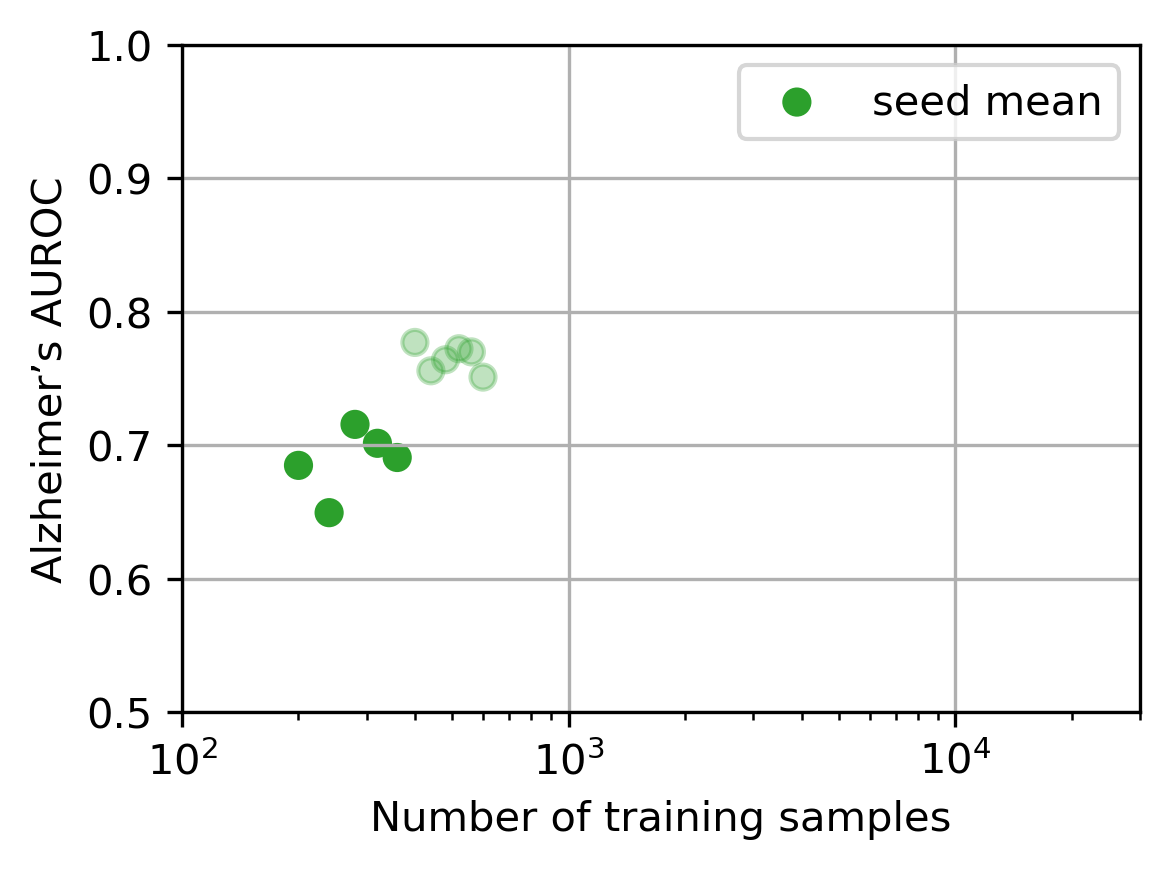

In [11]:
def get_alpha(n):
    if n <= 360:
        return 1.0
    else:
        return 0.3

def plot_experiment(df, labels, random_states=[1001, 2001, 3001]):
    df = df[df.random_state.isin(random_states)]
    colors = ['#2ca02c','#ff7f0e', '#9467bd']
    ncols = len(labels) if len(labels) < 4 else 4
    nrows = math.ceil(len(labels)/4)
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*4, nrows*3), dpi=300)
    for label_index, _ in enumerate(labels):
        # Train model
        """
        X_train, y_train, X_test, y_test = split_df(df, label_index)
        model = train_model(X_train, y_train)
        model.eval()
        with torch.no_grad():
            observed_pred = model(torch.linspace(100, 30000, 1000))
        np.array(axs).flatten()[label_index]\
        .plot(np.linspace(100, 30000, 1000), observed_pred.numpy(), color='#d62728', label='Power law')

        X_train, y_train, X_test, y_test = split_df(df, label_index)
        likelihood, model = train_GP(X_train, y_train)
        likelihood.eval()
        model.eval()
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            observed_pred = likelihood(model(torch.linspace(100, 30000, 1000)))
        upper = observed_pred.mean.numpy()+(3*observed_pred.stddev.numpy())
        lower = observed_pred.mean.numpy()-(3*observed_pred.stddev.numpy())
        observed_pred.mean.numpy()
        np.array(axs).flatten()[label_index]\
        .plot(np.linspace(100, 30000, 1000), observed_pred.mean.numpy(), color='#1f77b4', label='Gaussian process (ours)')
        np.array(axs).flatten()[label_index]\
        .fill_between(np.linspace(100, 30000, 1000), lower, upper, color='#1f77b4', alpha=0.1)
        """        
        for color, random_state in zip(colors, random_states):
            # Plot data
            temp_df = df[df.random_state==random_state]
            np.array(axs).flatten()[label_index]\
            .scatter(temp_df.n.to_numpy(),
                     np.array(temp_df.val_auroc.to_list())[:,label_index],
                     color = color,
                     alpha=list(map(get_alpha, df.n[df.random_state==random_state].to_list())),
                     label='seed {}'.format(random_state))
        np.array(axs).flatten()[label_index]\
        .set_xlim([100, 30000])
        np.array(axs).flatten()[label_index]\
        .set_ylim([0.5, 1.0])
        np.array(axs).flatten()[label_index]\
        .set_xscale('log')
        np.array(axs).flatten()[label_index]\
        .set_xlabel('Number of training samples')
        np.array(axs).flatten()[label_index]\
        .set_ylabel('{} AUROC'.format(labels[label_index]))
        np.array(axs).flatten()[label_index]\
        .legend()
        np.array(axs).flatten()[label_index]\
        .grid()
    fig.tight_layout()
    plt.show()
    
#"""
df = df.groupby('n').agg(lambda x: list(x))
df.test_auroc = df.test_auroc.apply(lambda x: np.mean(x, axis=0))
df.random_state = df.random_state.apply(lambda x: 'mean')
df = df.reset_index()
#"""
#plot_experiment(df, ['Alzheimer’s'], random_states)
plot_experiment(df, ['Alzheimer’s'], ['mean'])